## Train DBP

In [3]:
"""
Train MetaDSP Model with split windows.
"""

import pickle, torch, numpy as np, time, argparse, os , yaml, jax
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from functools import partial
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from src.TorchDSP.core import TorchInput, TorchSignal, TorchTime
from src.TorchDSP.dsp import DSP, LDBP, downsamp, ADF, TestDBP
from src.TorchDSP.train_dbp import Test, Train
from src.TorchDSP.dataloader import  MyDataset
from src.TorchDSP.loss import BER_well, MSE, SNR, Qsq
from src.TorchSimulation.receiver import  BER
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf
import src.JaxSimulation.adaptive_filter as af
from src.JaxSimulation.core import MySignal, SigTime

with open('configs/metadsp/dbp_info.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
cfg

{'train_path': 'dataset_A800/train.h5',
 'test_path': 'dataset_A800/test.h5',
 'DBP_info': {'Nmodes': 2,
  'step': 5,
  'dtaps': 5401,
  'ntaps': 401,
  'd_share': True,
  'n_share': True},
 'epochs': 30,
 'save_interval': 10,
 'batch_size': 20,
 'tbpl': 2000,
 'device': 'cuda:0',
 'scheduler_step': 10}

Phase rotation free loss function
$$
loss(x,y) = \frac{1}{N}\sum_{i=1}^N |x_i \exp(-i\phi)  - y_i|^2, \quad \phi = \arg\left(\sum_{i=1}^N x_i y_i^*\right)
$$

## Experiment

In [ ]:
Qp = {}

## set parameters

train_pch = [2]     # train power of the signal
d_share = False
n_share = False


# step = 400
# dtaps = 101
# ntaps = 1
# epochs = 30
# scheduler_step = 10
# scheduler_decay = 0.5
# D_lr = 0
# N_lr = 1e-2
# conv_lr = 3e-2
# tbpl = 10000
# batch_size = 2
# Nwindow = 1000

step = 5
dtaps = 8001
ntaps = 401
epochs = 30
scheduler_step = 10
scheduler_decay = 0.1
D_lr = 0
N_lr = 3e-4
conv_lr = 3e-3
tbpl = 2000
batch_size = 10 
Nwindow = 10000


################################

shuffle = True      # shuffle data or not
conv_taps = 64      # static conv taps.


################################

cfg['DBP_info']['step'] = step
cfg['DBP_info']['dtaps'] = dtaps
cfg['DBP_info']['ntaps'] = ntaps
cfg['DBP_info']['d_share'] = d_share
cfg['DBP_info']['n_share'] = n_share
cfg['tbpl'] = tbpl 
cfg['batch_size'] = batch_size
cfg['epochs'] = epochs


####################################

Q_crs = []
Filters = []
Epoch = 0
for rs in [160]:
    net = TestDBP(**cfg['DBP_info'], Fs=rs*2e9)
    conv = downsamp(taps=conv_taps, Nmodes=cfg['DBP_info']['Nmodes'], sps=2, init='zeros')
    net.to(cfg['device'])
    conv.to(cfg['device'])

    optimizer = torch.optim.Adam([{'params': net.Dkernel_real, 'lr': D_lr},{'params': net.Dkernel_imag, 'lr': D_lr}, {'params': net.Nkernel, 'lr': N_lr}, {'params': conv.parameters(), 'lr': conv_lr}])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_decay)

    train_data = MyDataset(cfg['train_path'], Nch=[21], Rs=[rs], Pch=2, Nmodes=cfg['DBP_info']['Nmodes'],
                        window_size=cfg['tbpl'] + net.overlaps + conv.overlaps, strides=cfg['tbpl'], 
                        Nwindow=Nwindow, truncate=0, Tx_window=True, pre_transform='Rx')
    train_loader = DataLoader(train_data, batch_size=cfg['batch_size'], shuffle=shuffle, drop_last=True)

    print('data batchs:', len(train_loader))
    # log_path = f'_outputs/log_tensorboard/train_dbp/trainpch{train_pch}_Dshare{d_share}_D{D_lr}_Nshare{n_share}_N{N_lr}_step{step}_dtaps{dtaps}_ntaps{ntaps}'
    log_path = f'_outputs/log_tensorboard/train_dbp/test'

    test_info = {'Nch':21, 'Rs': rs, 'power':4}
    Train(net, conv, train_loader, optimizer, scheduler, log_path, Epoch,  cfg['epochs'], test_info=test_info,  save_log=True, save_model=False, save_interval=10, device=cfg['device'])
    Epoch = Epoch + cfg['epochs']
    Q_crs.append([np.max([Test(net, 'cuda:0', taps=32, power=p, Nch=21, Rs=test_rs)['Qsq'] for p in range(-3, 5)]) for test_rs in [40, 80, 160]])
    Filters.append(net.Nkernel[0].data.cpu())
    # Qp[str(train_pch[0])] = [Test(net, 'cuda:0', taps=32, power=p)['Qsq'] for p in range(-3, 8)]

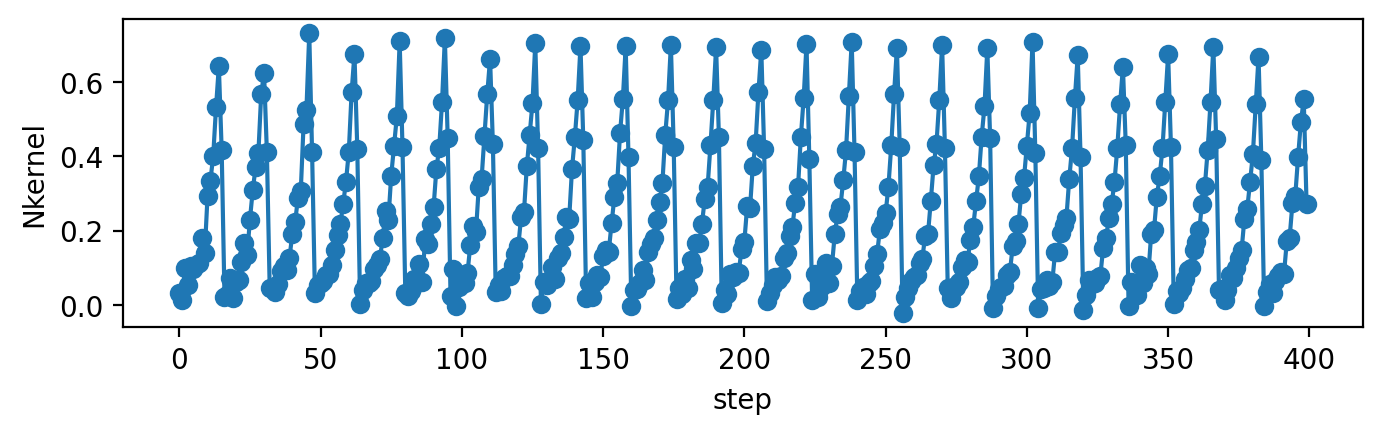

In [25]:
import matplotlib.pyplot as plt

plt.figure(dpi=200, figsize=(8,2))
plt.plot([torch.mean(net.Nkernel[i][:,:,0]).item() for i in range(400)], '-o')
plt.xlabel('step')
plt.ylabel('Nkernel')
plt.show()

## show Q-P curve (real time)

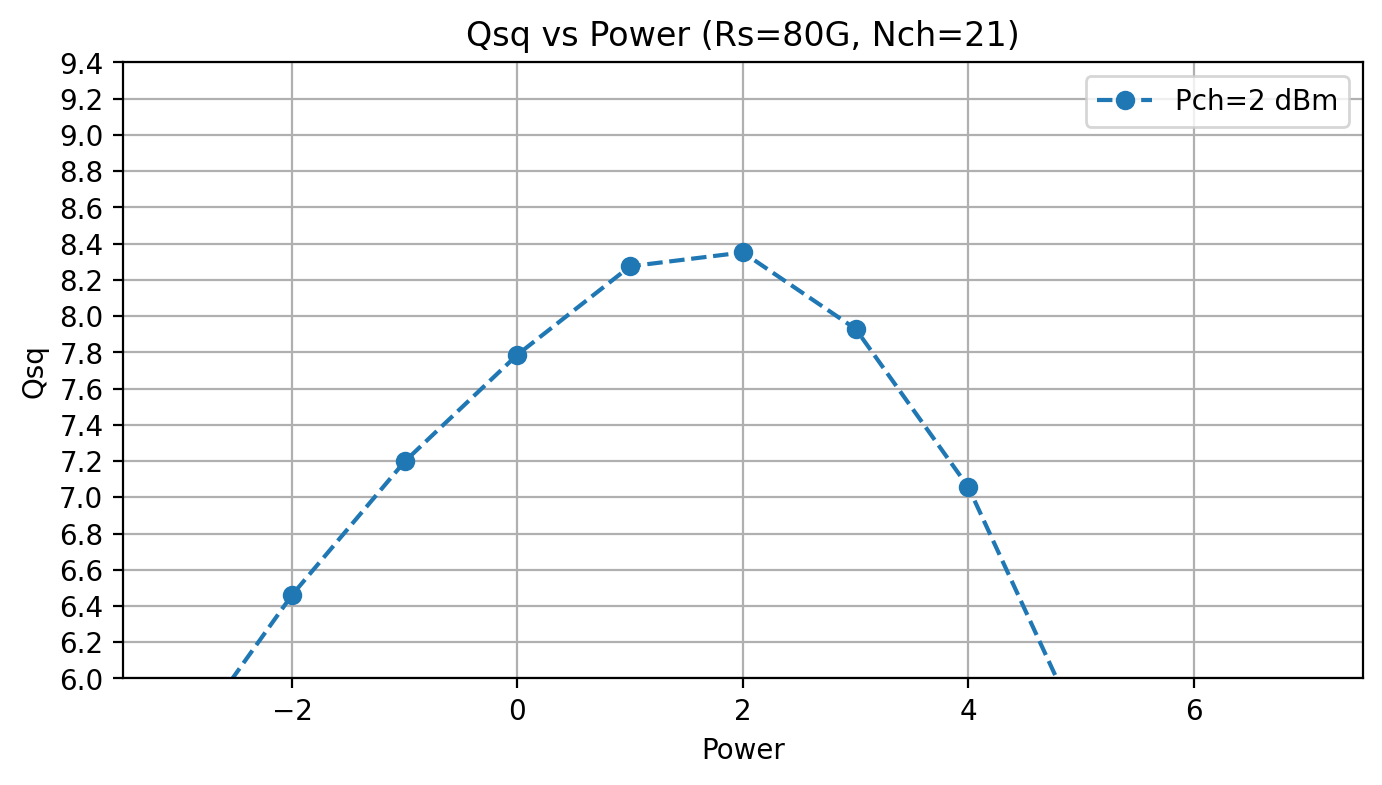

In [5]:
import matplotlib.pyplot as plt
plt.figure(dpi=200, figsize=(8,4))
for key in Qp.keys():
    plt.plot(range(-3, 8), Qp[key], '--o', label=f'Pch={key} dBm')

plt.legend()
plt.ylim(6, 9)
plt.yticks(np.arange(6, 9.5, 0.2))
plt.xlabel('Power')
plt.ylabel('Qsq')
plt.title('Qsq vs Power (Rs=80G, Nch=21)')
plt.grid()

In [4]:
dbp = LDBP(config['model_info']['DBP_info'])
device = 'cuda:0'
dbp.load_state_dict(torch.load('_models/metadsp/train_dbp/net_40.pth'))
dbp.to(device)
Qp2 = [Test(dbp, device, taps=32, power=p)['Qsq'] for p in range(-3, 8)]

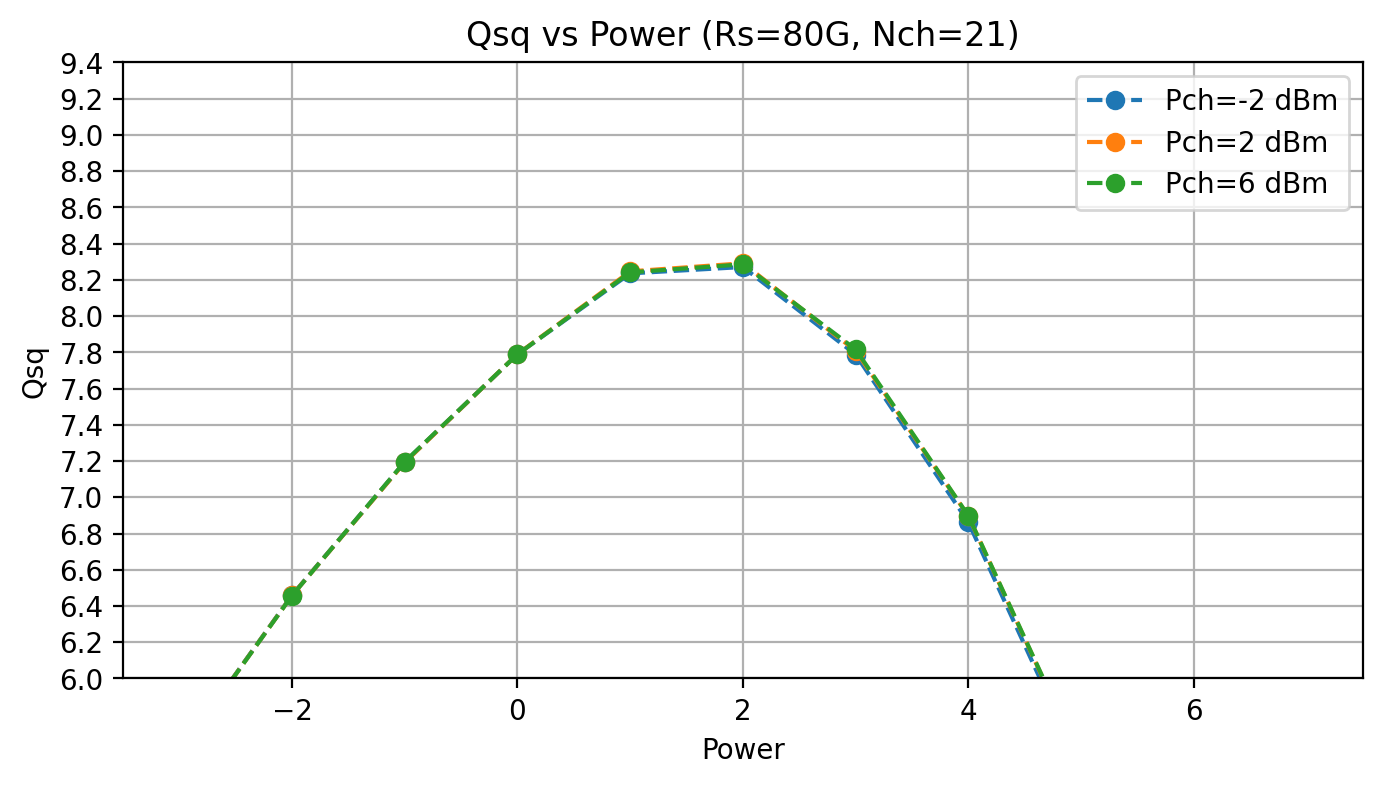

In [34]:
import matplotlib.pyplot as plt

plt.figure(dpi=200, figsize=(8,4))
for key in Qp.keys():
    plt.plot(range(-3, 8), Qp[key], '--o', label=f'Pch={key} dBm')
plt.legend()
plt.ylim(6, 9)
plt.yticks(np.arange(6, 9.5, 0.2))
plt.xlabel('Power')
plt.ylabel('Qsq')
plt.title('Qsq vs Power (Rs=80G, Nch=21)')
plt.grid()

##  show N-filter (real time)

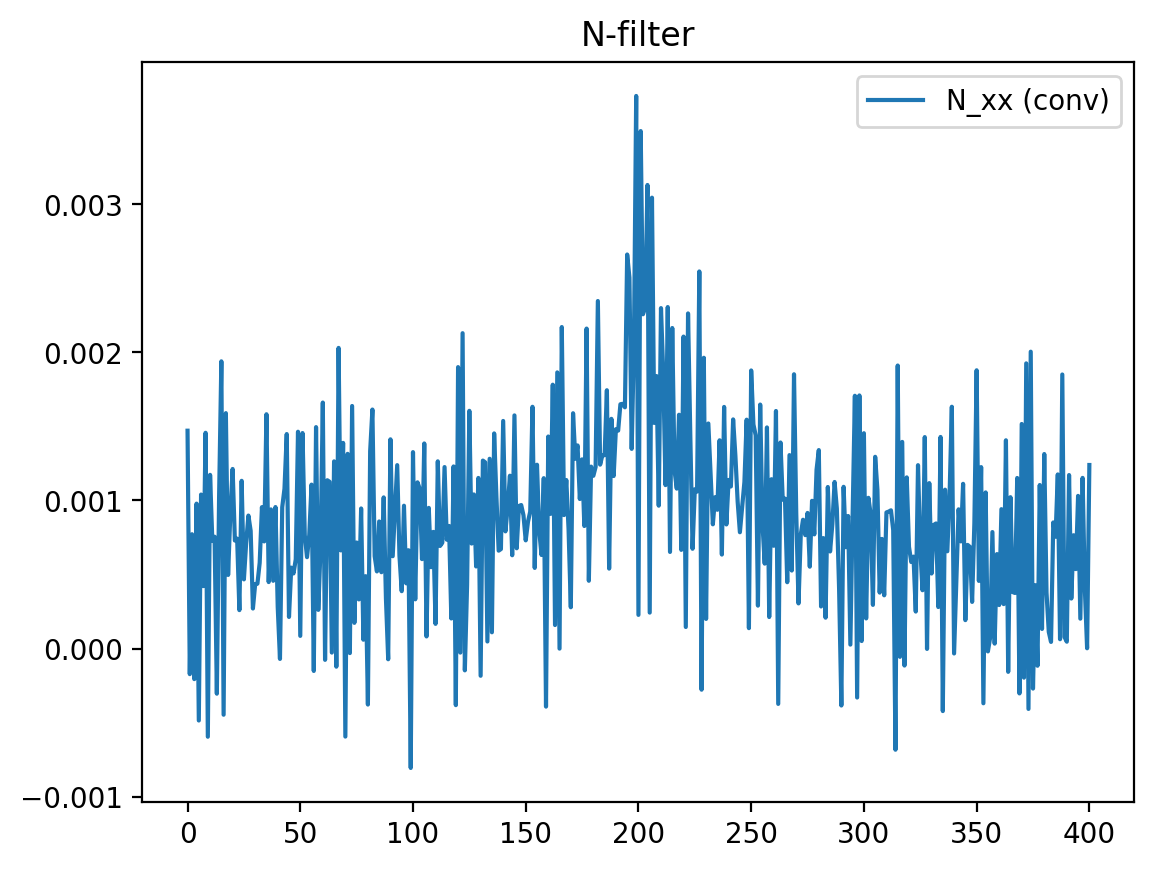

In [14]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)


plt.plot(net.Nkernel[0].data.cpu()[0,0], label='N_xx (conv)')
# plt.plot(net.Nkernel[0].data.cpu()[0,1], label='N_xy (conv)')
# plt.plot(net.Nkernel[0].data.cpu()[1,0], label='N_yx (conv)')
# plt.plot(net.Nkernel[0].data.cpu()[1,1], label='N_yy (conv)')
plt.title('N-filter')

# plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[0,0].cpu().data, label='N_xx (adf)')
# plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[0,1].cpu().data, label='N_xy (adf)')
# plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[1,0].cpu().data, label='N_yx (adf)')
# plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[1,1].cpu().data, label='N_yy (adf)')
plt.legend()

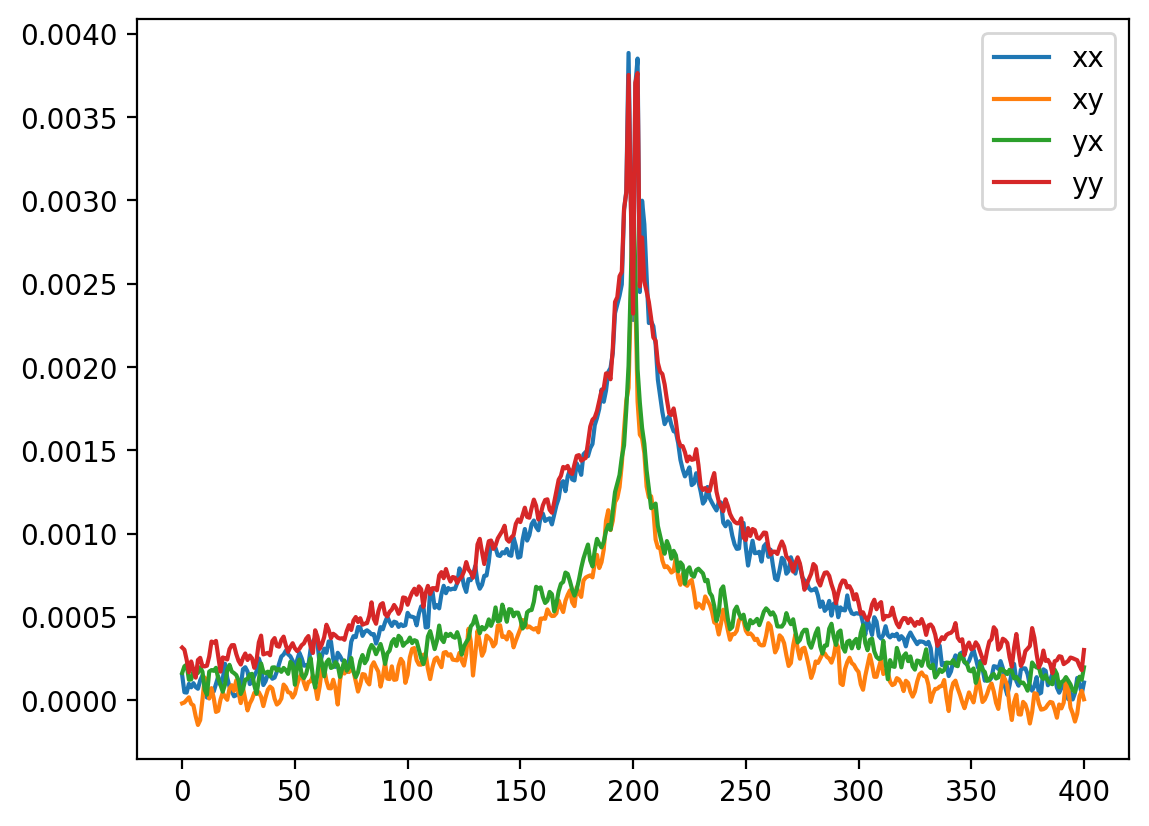

In [7]:
dic = torch.load('_models/metadsp/fdbp/61.pth')
dic['model info']['DBP_info']['share'] = True
model = DSP(**dic['model info'])
model.load_state_dict(dic['model'])
model = model.to('cuda:0')

import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[0,0].cpu().data, label='xx')
plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[0,1].cpu().data, label='xy')
plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[1,0].cpu().data, label='yx')
plt.plot(model.ldbp.task_mlp(torch.ones(1)).reshape(2,2,401)[1,1].cpu().data, label='yy')
plt.legend()

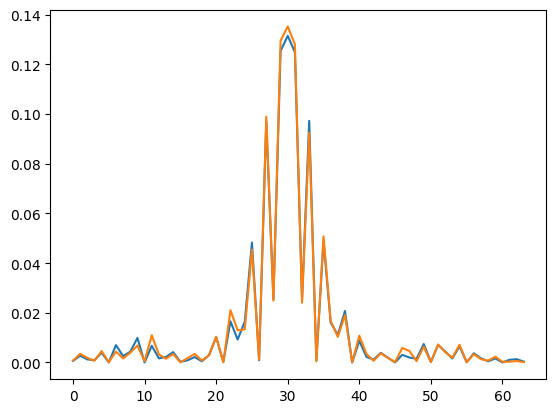

In [36]:
plt.plot(conv.conv.conv1d_r.weight[0,0].cpu().data**2 + conv.conv.conv1d_r.weight[0,0].cpu().data**2)
plt.plot(conv.conv.conv1d_r.weight[1,1].cpu().data**2 + conv.conv.conv1d_r.weight[1,1].cpu().data**2)

## show Q-table from tensorboard

In [5]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def get_Q(tbpl, batch, shuffle):
    logdir = f'_outputs/log_tensorboard/metadsp/train_dbp_tbpl{tbpl}_batch{batch}_shuffle{shuffle}_lrDBP0.0003_lrConv0.003_loss{loss_fn.__name__}'  # TensorBoard 日志文件路径
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()

    return event_acc.Scalars('Metric/Qsq')[-1].value

def get_time(tbpl, batch, shuffle):
    # get time (min)
    logdir = f'_outputs/log_tensorboard/metadsp/train_dbp_tbpl{tbpl}_batch{batch}_shuffle{shuffle}_lrDBP0.0003_lrConv0.003_loss{loss_fn.__name__}'  # TensorBoard 日志文件路径
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()

    return (event_acc.Scalars('Metric/Qsq')[-1].wall_time - event_acc.Scalars('Metric/Qsq')[0].wall_time)/60

In [6]:
# Q0 = [[get_Q(tbpl, k, False) for k in [1, 10, 20]] for tbpl in [250, 500, 1000, 2000, 4000]]
# Q1 = [[get_Q(tbpl, k, True) for k in [1, 10, 20]] for tbpl in [250, 500, 1000, 2000, 4000]]
Q0 = [[get_Q(tbpl, k, False) for k in [1, 10, 20]] for tbpl in [1000, 2000, 4000]]
Q1 = [[get_Q(tbpl, k, True) for k in [1, 10, 20]] for tbpl in [1000, 2000, 4000]]

In [7]:
T0 = [[get_time(tbpl, k, True) for k in [1, 10, 20]] for tbpl in [1000, 2000, 4000]]

Text(0.5, 1.0, 'Training time (min)')

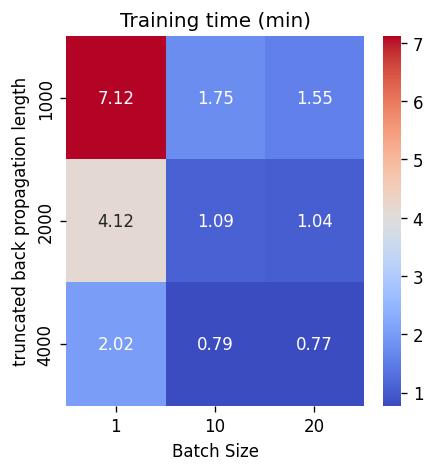

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt

# show Q0 in a hitmap with .3f scheme, set range of color bar to -0.1 to 0.1
plt.figure(dpi=120, figsize=(4,4))
sns.heatmap(np.array(T0), annot=True, fmt='.2f', cmap='coolwarm', xticklabels=[1, 10, 20], yticklabels=[1000, 2000, 4000])

plt.xlabel('Batch Size')
plt.ylabel('truncated back propagation length')
plt.title('Training time (min)')


## show Q-P from tensorboard

In [3]:
import numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dataloader import baselines
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def get_Q2(train_pch, d_share, n_share, D_lr, N_lr, step, dtaps, ntaps):
    logdir = f'_outputs/log_tensorboard/train_dbp/trainpch{train_pch}_Dshare{d_share}_D{D_lr}_Nshare{n_share}_N{N_lr}_step{step}_dtaps{dtaps}_ntaps{ntaps}'  # TensorBoard 日志文件路径
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()

    return event_acc.Scalars('Metric/Qsq')[-1].value

def get_Qp(train_pch, d_share, n_share, D_lr, N_lr, step, dtaps, ntaps):
    logdir = f'_outputs/log_tensorboard/train_dbp/trainpch{train_pch}_Dshare{d_share}_D{D_lr}_Nshare{n_share}_N{N_lr}_step{step}_dtaps{dtaps}_ntaps{ntaps}'  # TensorBoard 日志文件路径
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()
    return np.arange(-3, 8), [s.value for s in event_acc.Scalars('Qp(-3 : 8 dBm)')]

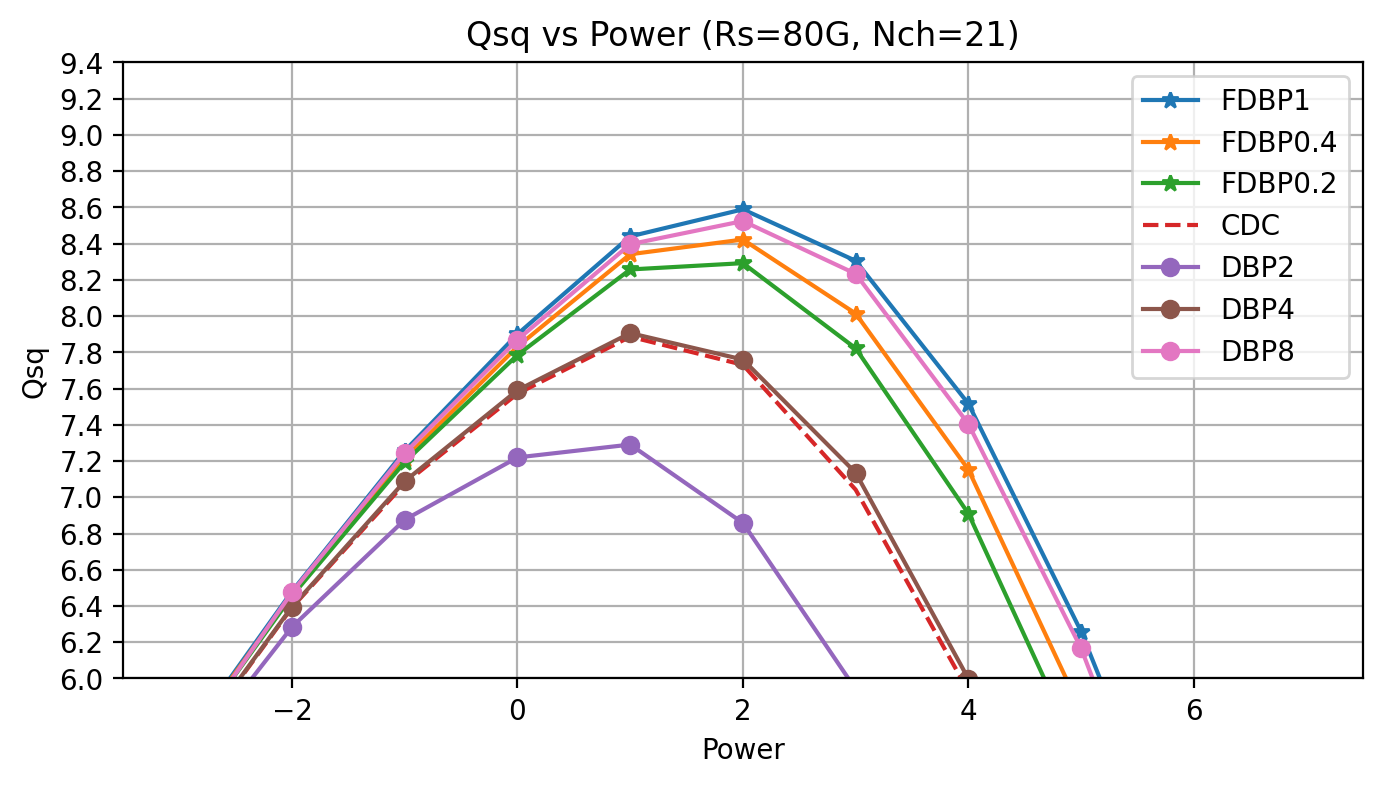

In [4]:
Q = baselines('dataset_A800/test.h5', 21, 80, P=np.arange(-3, 8))

# P, Qp1 = get_Qp([2], True, True, 0, 3e-4, 25, 1001, 101)
# P, Qp2 = get_Qp([2], True, True, 0, 3e-4, 10, 2501, 201)
# P, Qp3 = get_Qp([2], True, True, 0, 3e-4, 5, 5401, 401)
P, Qp1 = get_Qp([2,3,4,5,6], True, False, 0, 3e-4, 25, 1001, 101)
P, Qp2 = get_Qp([2,3,4,5,6], True, False, 0, 3e-4, 10, 2501, 201)
P, Qp3 = get_Qp([2,3,4,5,6], True, False, 0, 3e-4, 5, 5401, 401)

plt.figure(dpi=200, figsize=(8,4))


plt.plot(P, Qp1, '-*', label='FDBP1')
plt.plot(P, Qp2, '-*', label='FDBP0.4')
plt.plot(P, Qp3, '-*', label='FDBP0.2')

plt.plot(P, Q['CDC'], '--', label='CDC')

for key in ['DBP2', 'DBP4', 'DBP8']:
    plt.plot(P, Q[key], '-o', label=key)

plt.legend()
plt.ylim(6, 9)
plt.yticks(np.arange(6, 9.5, 0.2))
plt.xlabel('Power')
plt.ylabel('Qsq')
plt.title('Qsq vs Power (Rs=80G, Nch=21)')
plt.grid()

### 1. Train dfilter or not

In [14]:
get_Q2([2], True, True, 1e-4, 3e-4, 5, 5401, 401)

6.135791301727295

In [12]:
get_Q2([2], True, True, 0, 3e-4, 25, 1001, 101)

8.593276023864746

In [15]:
get_Q2([2], False, False, 1e-4, 3e-4, 25, 1001, 101)

0.22776028513908386

In [4]:
for d_share in [True, False]:
    for n_share in [True, False]:
        print('d_share:', d_share, 'n_share:', n_share)
        # print(get_Q2([2], d_share, n_share, 0, 3e-4, 25, 1001, 101))
        print(get_Q2([2], d_share, n_share, 0, 3e-4, 10, 2501, 201))


import seaborn as sns
import matplotlib.pyplot as plt

# show Q0 in a hitmap with .3f scheme, set range of color bar to -0.1 to 0.1
plt.figure(dpi=120, figsize=(4,4))
sns.heatmap(np.array(T0), annot=True, fmt='.2f', cmap='coolwarm', xticklabels=[1, 10, 20], yticklabels=[1000, 2000, 4000])

plt.xlabel('Batch Size')
plt.ylabel('truncated back propagation length')
plt.title('Training time (min)')


d_share: True n_share: True
8.40088939666748
d_share: True n_share: False
8.383801460266113
d_share: False n_share: True
8.407486915588379
d_share: False n_share: False
8.384162902832031
